# Background

## Data Description

Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.


### Attributes:

| Column	|Description|
|-|-|
|age	|Age of customer (numeric)|
|job	|Type of job (categorical)|
|marital	|Marital status (categorical)|
|education	|Education level (categorical)|
|default	|Has credit in default? (binary)|
|balance	|Average yearly balance, in euros (numeric)|
|housing	|Has a housing loan? (binary)|
|loan	|Has personal loan? (binary)|
|contact	|Contact communication type (categorical)|
|day	|Last contact day of the month (numeric)|
|month	|Last contact month of the year (categorical)|
|duration	|Last contact duration, in seconds (numeric)|
|campaign	|Number of contacts performed during this campaign and for this client (numeric, includes last contact)|

### Output (desired target):

$y$ - has the client subscribed to a term deposit? (binary)

### Goal(s):

- Predict if the customer will subscribe (yes/no) to a term deposit (variable y)
- Find customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
- What makes the customers buy? 


### Success Metric(s):

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import xgboost as xgb

In [2]:
csv_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'term-deposit-marketing-2020.csv'))

## Exploratory data analysis using, JupySQL, SQL queries and DuckDB

**Note**

The queries below asume the usage of JupySQL and Jupyter notebooks.

Ensure the following are installed

```
duckdb-engine
jupysql
```

In [3]:
%load_ext sql
%sql duckdb:///:memory:

In [4]:
query = f"""
CREATE TABLE term_deposit_marketing AS SELECT * FROM read_csv_auto('{csv_path}')
"""

%sql {{query}}


*  duckdb:///:memory:
Done.


Count
40000


In [5]:
f5 = """
    SELECT * FROM term_deposit_marketing LIMIT 5;
"""

%sql {{f5}}

*  duckdb:///:memory:
Done.


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Building the model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn import metrics

In [29]:
full_data = %sql SELECT * FROM term_deposit_marketing;
data = full_data.DataFrame()


*  duckdb:///:memory:
Done.


In [8]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


Preprocess the data

In [10]:
# Prepare target variable
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Define feature columns and target column
X = data.drop(columns=['y','month','day','contact'])
y = data['y']

Split the data into training and testing datasets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Create a preprocessing pipeline

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

def generate_pipeline(X, model):
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    # Define transformers for categorical and numerical columns
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = StandardScaler()

    # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Create a pipeline with preprocessing, SMOTE, and the classifier
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])
    
    return pipeline


Create a pipeline and fit the model

In [13]:
# Create a pipeline with preprocessing and XGBClassifier
model = xgb.XGBClassifier(random_state=42, )

pipeline = generate_pipeline(X, model)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Calculate the average accuracy
avg_accuracy = cv_scores.mean()

print("5-fold Cross-validation Accuracy:", avg_accuracy)

success_metric = 0.81

if avg_accuracy >= success_metric:
    print("Success: The average accuracy is above or equal to the success metric.")
else:
    print("Failure: The average accuracy is below the success metric.")


5-fold Cross-validation Accuracy: 0.9236249999999998
Success: The average accuracy is above or equal to the success metric.


Make predictions and evaluate

In [14]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=No...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [15]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9309166666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     11128
           1       0.55      0.26      0.36       872

    accuracy                           0.93     12000
   macro avg       0.75      0.62      0.66     12000
weighted avg       0.92      0.93      0.92     12000



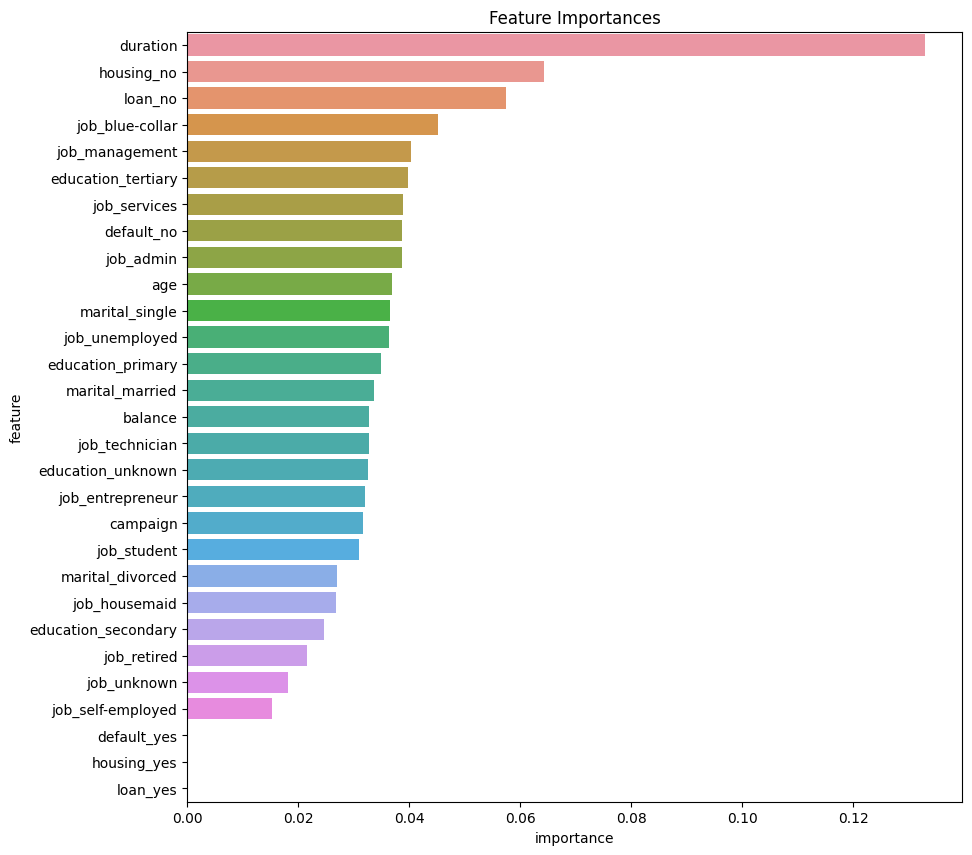

In [24]:
# Train the pipeline
pipeline.fit(X_train, y_train)

# Get feature importances
importances = pipeline.named_steps['classifier'].feature_importances_

# Get feature names
numerical_feature_names = X.select_dtypes(exclude=['object']).columns.tolist()
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=X.select_dtypes(include=['object']).columns.tolist())

feature_names = numerical_feature_names + categorical_feature_names.tolist()

# Create a dataframe with feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by feature importance
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)


# Plot the feature importances
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importances, x='importance', y='feature')
plt.title('Feature Importances')
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'feature-importances.png')))

In [17]:
# For a new customer
new_customer_data = X  # Fill in the new customer's information in the appropriate format
y_pred = pipeline.predict(new_customer_data)


In [18]:
# Estimate probabilities
probabilities = pipeline.predict_proba(new_customer_data)

# Set a threshold for prioritizing customers
threshold = 0.7

# Find customers with a higher probability of subscribing
high_priority_customers = new_customer_data[probabilities[:, 1] >= threshold]

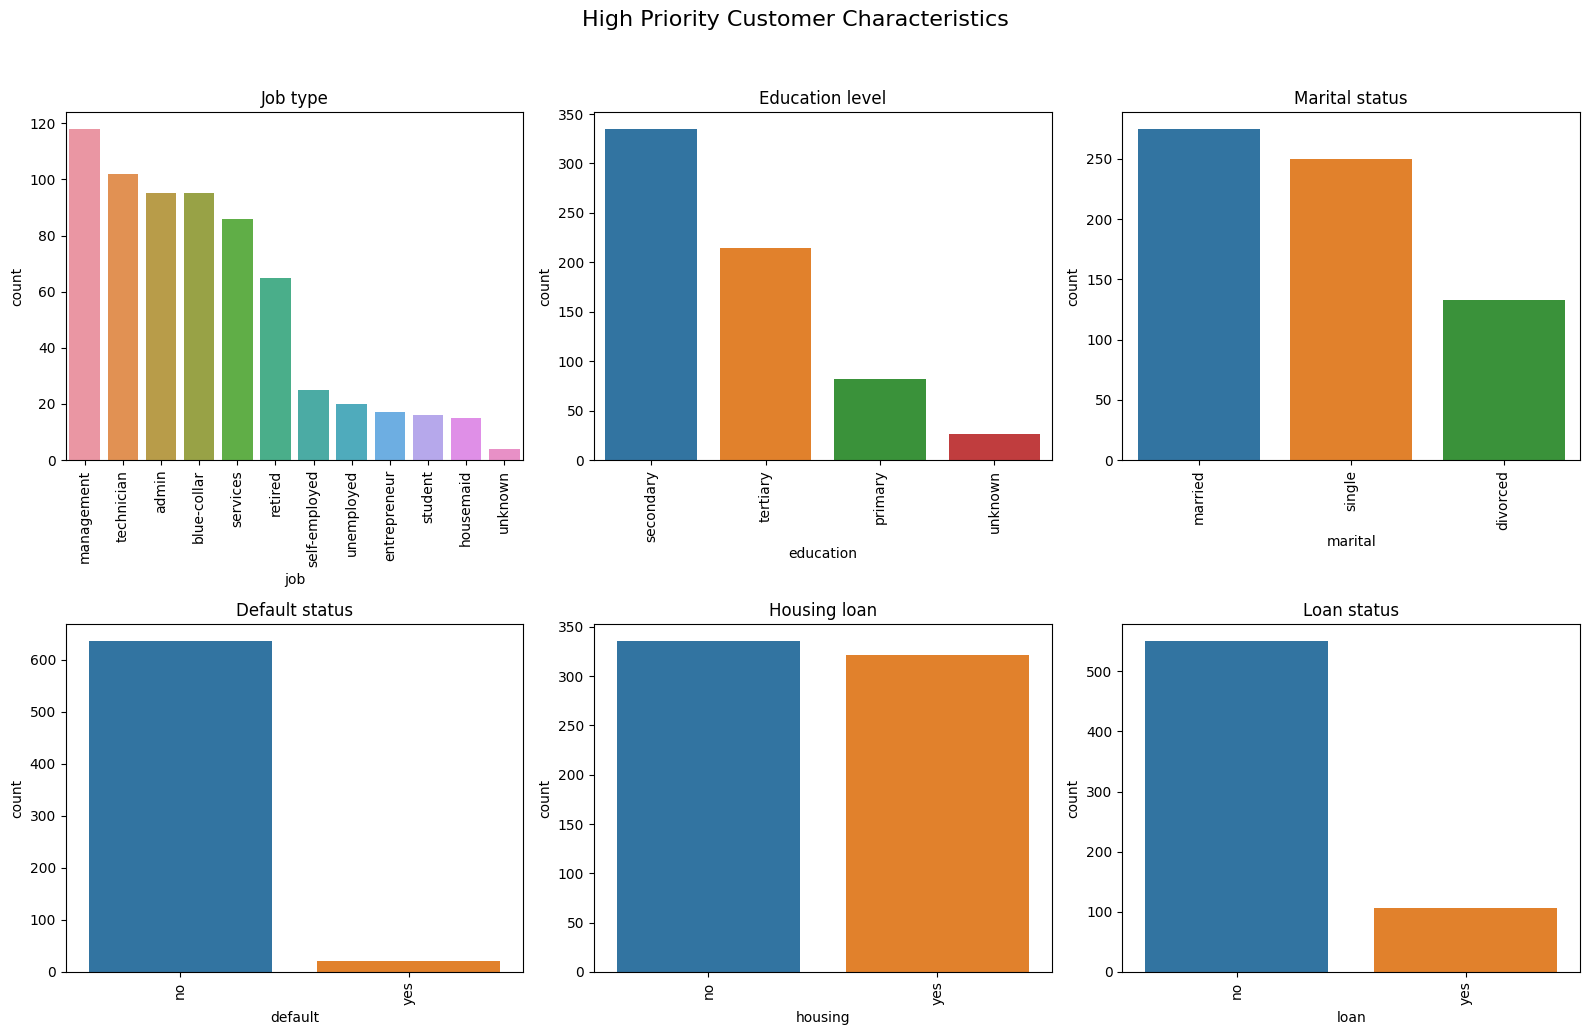

In [62]:


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
fig.suptitle('High Priority Customer Characteristics', fontsize=16, y=1.03)
# Job
sns.countplot(x='job', data=high_priority_customers, ax=axes[0, 0], order=high_priority_customers['job'].value_counts().index)
axes[0, 0].set_title('Job type')
axes[0, 0].tick_params(axis='x', rotation=90)

# Education
sns.countplot(x='education', data=high_priority_customers, ax=axes[0, 1])
axes[0, 1].set_title('Education level')
axes[0, 1].tick_params(axis='x', rotation=90)

# Marital
sns.countplot(x='marital', data=high_priority_customers, ax=axes[0, 2], order=high_priority_customers['marital'].value_counts().index)
axes[0, 2].set_title('Marital status')
axes[0, 2].tick_params(axis='x', rotation=90)

# Default
sns.countplot(x='default', data=high_priority_customers, ax=axes[1, 0], order=high_priority_customers['default'].value_counts().index)
axes[1, 0].set_title('Default status')
axes[1, 0].tick_params(axis='x', rotation=90)

# Housing
sns.countplot(x='housing', data=high_priority_customers, ax=axes[1, 1], order=high_priority_customers['housing'].value_counts().index)
axes[1, 1].set_title('Housing loan')
axes[1, 1].tick_params(axis='x', rotation=90)

# Loan
sns.countplot(x='loan', data=high_priority_customers, ax=axes[1, 2], order=high_priority_customers['loan'].value_counts().index)
axes[1, 2].set_title('Loan status')
axes[1, 2].tick_params(axis='x', rotation=90)

plt.tight_layout()



# Save the plot
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'customer-segmentation.png')), bbox_inches='tight')


In [26]:
# Print top 5 most important features
print(feature_importances.head(15))

               feature  importance
0             duration    0.132949
1           housing_no    0.064218
2              loan_no    0.057384
3      job_blue-collar    0.045186
4       job_management    0.040361
5   education_tertiary    0.039835
6         job_services    0.038777
7           default_no    0.038734
8            job_admin    0.038675
9                  age    0.036957
10      marital_single    0.036519
11      job_unemployed    0.036256
12   education_primary    0.034809
13     marital_married    0.033588
14             balance    0.032801


In [ ]:
# convert duration from seconds to minutes

data['duration_m'] = data['duration'].apply(lambda x: x/60)
data['y_mapped'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

Text(0.5, 1.0, 'Duration of Calls by Subscription Status')

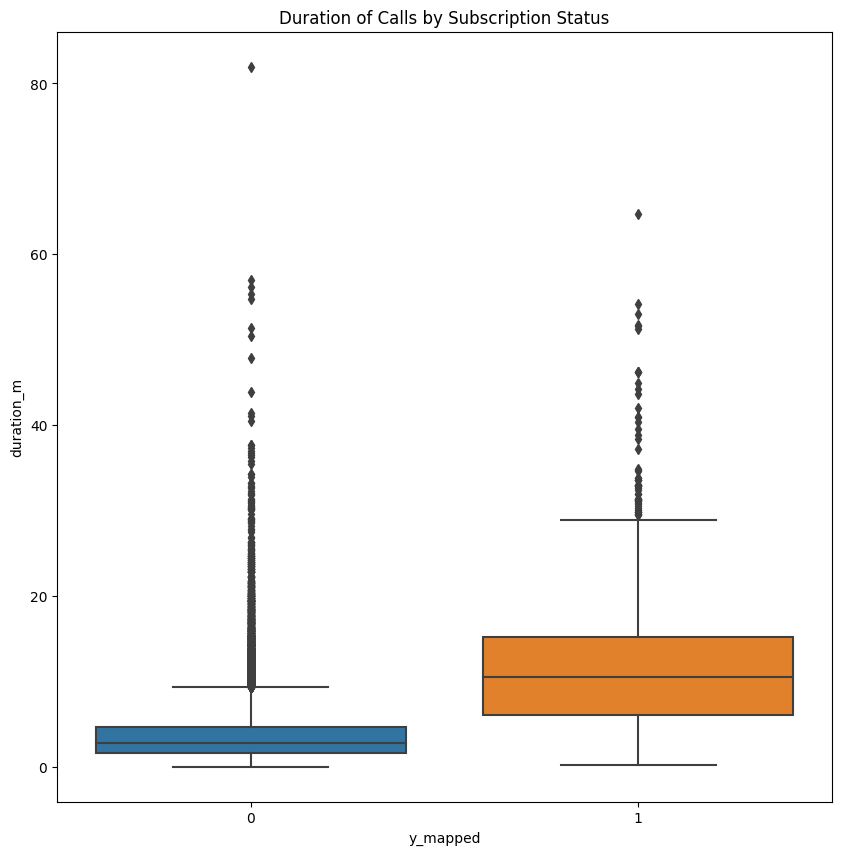

In [43]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='y_mapped', y='duration_m', data=data)
plt.title('Duration of Calls by Subscription Status')


Text(0.5, 1.0, 'Distribution of duration_m')

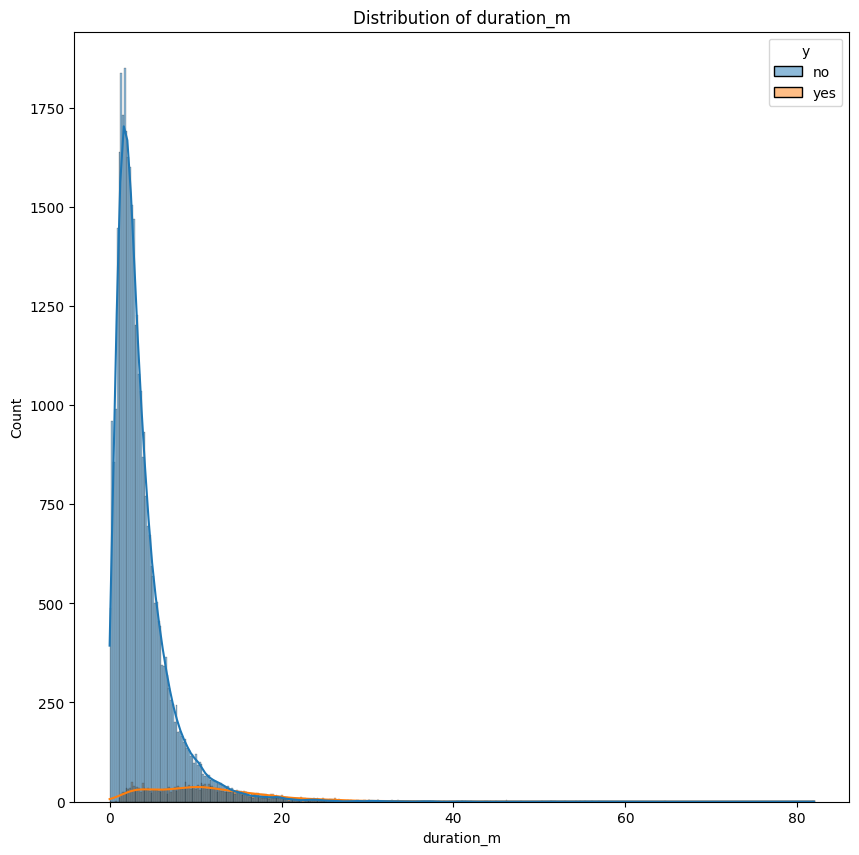

In [33]:

plt.figure(figsize=(10, 10))
sns.histplot(data=data, x='duration_m', hue='y', kde=True)
plt.title('Distribution of duration_m')